# Gridding a synthetic ground survey

Let's perform a synthetic ground survey of the synthetic model made out of prisms and try to interpolate the observed data on a regular grid.
Because the model is synthetic, we can compute the true value of the field on this regular grid. Therefore, we have an objective way to score the interpolation. This allow us to objectively compare the different source layouts.

**Import useful packages**

In [1]:
from IPython.display import display, HTML
import itertools
import numpy as np
import pandas as pd
import verde as vd
import harmonica as hm
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

from eql_source_layouts import (
    ground_survey,
    synthetic_model,
    variable_relative_depth,
    block_reduce_points,
)

**Define parameters used on the gridding**

In [2]:
# Define a survey region of 100km x 100km
region = (-50e3, 50e3, -50e3, 50e3)

# And the region for building the synthetic model
model_region = tuple(list(region) + [-10e3, 0])

# Define which field will be meassured
field = "g_z"
field_units = "mGal"

# Define the spacing of the target regular grid
# and its observation height
grid_spacing = 1e3
grid_elevation = 2200

Define set of interpolation parameters

In [3]:
dampings = [None, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
relative_depths = [100, 500, 1000, 2000, 3000]
parameters_sets = [
    dict(damping=combo[0], relative_depth=combo[1])
    for combo in itertools.product(dampings, relative_depths)
]

**Define functions to plot gridding results**

In [4]:
def plot_prediction(
    grid,
    prediction,
    target,
    title="Prediction",
    figsize=(12, 6),
    shrink_cbar=0.7,
):
    """
    Plot prediction and comparison with target
    """
    fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=figsize)
    tmp = ax1.pcolormesh(*grid[:2], prediction)
    plt.colorbar(tmp, ax=ax1, shrink=shrink_cbar, label=field_units)
    ax1.set_aspect("equal")
    ax1.set_title(title)

    maxabs = vd.maxabs(target - prediction)
    tmp = ax2.pcolormesh(
        *grid[:2],
        target - best_prediction,
        vmin=-maxabs,
        vmax=maxabs,
        cmap="seismic",
    )
    plt.colorbar(tmp, ax=ax2, shrink=shrink_cbar, label=field_units)
    ax2.set_aspect("equal")
    ax2.set_title("Difference between target and prediction")
    plt.tight_layout()
    plt.show()

**Define function to print prediction parameters and scores with style**

In [5]:
def print_params_scores(parameters_sets, scores):
    """
    Display parameters and scores with style
    
    It also highlights the row that contains the maximum score
    """
    df = {}
    for keys in parameters_sets[0]:
        df[keys] = []
    df["score"] = []
    for parameters, score in zip(parameters_sets, scores):
        for key, param in parameters.items():
            df[key].append(param)
        df["score"].append(score)
    df = pd.DataFrame(df)
    display(df.style.apply(highlight_max_row, column="score", axis=None))


def highlight_max_row(df, column, color="orange"):
    """
    Highlight the row that contains the max value of a column
    """
    style = df.copy()
    is_max = (df[column] == df[column].max())
    background = [
        'background-color: {}'.format(color) if i else '' for i in is_max
    ]
    for col in style:
        style[col] = background
    return style

## Create the synthetic ground survey

To create the ground survey we need to load the synthetic model made out of prisms, the location of the observation points and then compute the field that the prisms generate on those points.

Get coordinates of observation points

In [6]:
survey = ground_survey(region)
survey.style

,easting,northing,elevation
6742,-49681.6,-49618,1296.61
6744,-48306,-48429.4,1322.21
6746,-47638.7,-38055.3,1285.02
6749,-46679.9,-39577.2,1287.77
6750,-46596.3,-46733.3,1383.17
6752,-45845.9,-41015.4,1295.39
6754,-44803.6,-45503.8,1350.86
6755,-44636.7,-42496.6,1342.63
6756,-44011.6,-44571.8,1329.53
6758,-43719.7,-44317.6,1323.12


Get the synthetic model

In [7]:
model = synthetic_model(model_region)
print(model.keys())
print("Number of prisms: {}".format(len(model["densities"])))

dict_keys(['prisms', 'densities'])
Number of prisms: 308


Compute the gravity field (g_z) on the observation points in mGal

In [8]:
coordinates = (survey.easting, survey.northing, survey.elevation)
survey[field] = hm.prism_gravity(
    coordinates,
    model["prisms"],
    model["densities"],
    field=field,
)
survey.style

,easting,northing,elevation,g_z
6742,-49681.6,-49618,1296.61,1.03468
6744,-48306,-48429.4,1322.21,1.19415
6746,-47638.7,-38055.3,1285.02,2.16771
6749,-46679.9,-39577.2,1287.77,2.19589
6750,-46596.3,-46733.3,1383.17,1.46786
6752,-45845.9,-41015.4,1295.39,2.1818
6754,-44803.6,-45503.8,1350.86,1.78076
6755,-44636.7,-42496.6,1342.63,2.20004
6756,-44011.6,-44571.8,1329.53,2.00126
6758,-43719.7,-44317.6,1323.12,2.07862


Plot the observed field

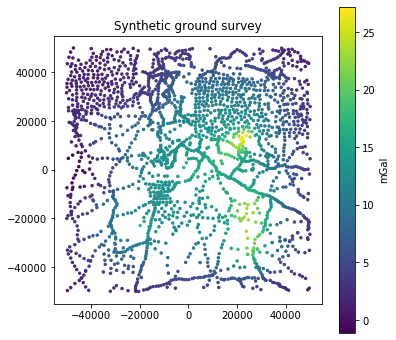

In [9]:
fig, ax = plt.subplots(figsize=(6, 6))
tmp = ax.scatter(survey.easting, survey.northing, c=getattr(survey, field), s=6)
plt.colorbar(tmp, ax=ax, label=field_units)
ax.set_aspect("equal")
ax.set_title("Synthetic ground survey")
plt.show()

## Compute the field of the synthetic model on a grid

Now, let's compute the gravity field that the synthetic model generates on the regular grid. These results will serve as a target for the interpolations using different source layouts.

Build the regular grid

In [10]:
grid = vd.grid_coordinates(
    region=region, spacing=grid_spacing, extra_coords=grid_elevation
)

Compute the synthetic gravity field on the grid

In [11]:
target = hm.prism_gravity(
    grid, model["prisms"], model["densities"], field=field
)

Plot target gravity field

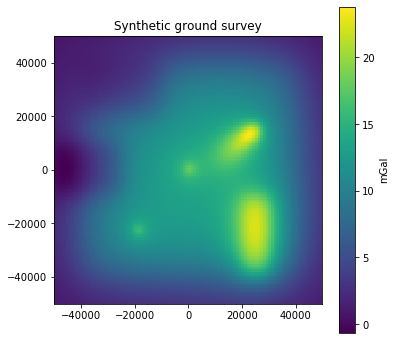

In [12]:
fig, ax = plt.subplots(figsize=(6, 6))
tmp = ax.pcolormesh(*grid[:2], target)
plt.colorbar(tmp, ax=ax, label=field_units)
ax.set_aspect("equal")
ax.set_title("Synthetic ground survey")
plt.show()

## Grid with one source beneath each data point and constant relative depth

Perform several interpolations on the grid by setting a single source point beneath each data point at a constant relative depth. This can be achieved throught `harmonica.EQLHarmonic` without any more work.
Each interpolation is performed with different values of the `damping` and `relative_depth` parameters. Then we score the prediction against the target field and store all these scores.

In [13]:
scores = []
for parameters in parameters_sets:
    # Initialize the gridder with one set of parameters
    eql = hm.EQLHarmonic(**parameters)
    
    # Fit the gridder giving the survey data
    eql.fit(coordinates, getattr(survey, field))
    
    # Predict the field on the regular grid
    prediction = eql.predict(grid)
    
    # Score the prediction against target data
    scores.append(r2_score(target, prediction))

Let's see all the computed scores. The highlight row indicates the set of parameters that produces the maximum score.

In [14]:
print_params_scores(parameters_sets, scores)

,damping,relative_depth,score
0,nan,100,0.46535
1,nan,500,0.878028
2,nan,1000,0.948999
3,nan,2000,0.981959
4,nan,3000,0.991056
5,1e-05,100,0.46535
6,1e-05,500,0.878028
7,1e-05,1000,0.948999
8,1e-05,2000,0.98196
9,1e-05,3000,0.991308


Keep the best prediction and plot it

Best score: 0.9913697331335211
Best parameters: {'damping': 0.0001, 'relative_depth': 3000}


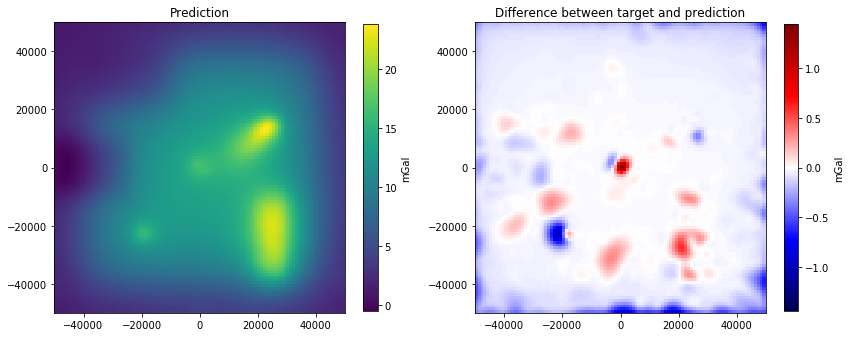

In [15]:
best = np.argmax(scores)
print("Best score:", scores[best])
print("Best parameters:", parameters_sets[best])

eql = hm.EQLHarmonic(**parameters_sets[best])
eql.fit(coordinates, getattr(survey, field))
best_prediction = eql.predict(grid)

plot_prediction(grid, best_prediction, target)